In [1]:
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
from scipy.misc import imsave
from scipy.misc import imresize
%matplotlib inline

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


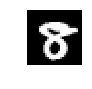

[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
8274 0.0 1.0


In [2]:
i = np.random.randint(0, 10000)
I = np.reshape(mnist.train.images[i], (28,28))

plt.imshow(I, cmap='gray')
plt.axis('off')
plt.gcf().set_size_inches(1, 1)
plt.show()
print(mnist.train.labels[i])
print(i, np.min(I), np.max(I))

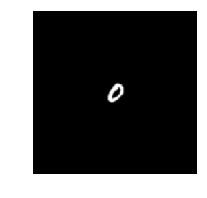

(240, 240)


In [25]:
# pad image
I = imresize(I, (40,40))
pad_amt = 100
Ipad = np.pad(I, ((pad_amt, pad_amt)), 'constant', constant_values = (0,0))
plt.imshow(Ipad, cmap='gray')
plt.axis('off')
plt.gcf().set_size_inches(3, 3)
plt.show()

print(np.shape(Ipad))

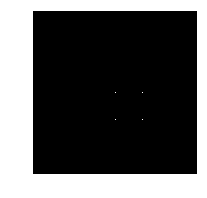

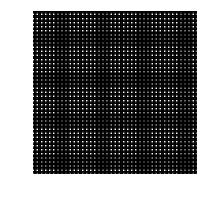

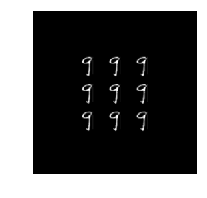

In [40]:
# PSF
dim = np.shape(Ipad)[0]
psf = np.zeros((dim, dim))
# psf[int(dim/2), int(dim/2) - int(np.shape(I)[0]/2)] = 1
# psf[int(dim/2), int(dim/2) + int(np.shape(I)[0]/2)] = 1

xvals = [80, 120, 160]
psf[xvals[0], xvals] = 1
psf[xvals[1], xvals] = 1
psf[xvals[2], xvals] = 1


plt.imshow(psf, cmap='gray')
plt.axis('off')
plt.gcf().set_size_inches(3, 3)
plt.show()

# convolve
otf = np.fft.fft2(np.fft.ifftshift(psf))
plt.imshow(np.square(np.fft.fftshift(np.abs(otf))), cmap='gray')
plt.axis('off')
plt.gcf().set_size_inches(3, 3)
plt.show()

Iout = np.fft.ifft2(np.fft.fft2(Ipad)*otf) 

plt.imshow(np.square(np.abs(Iout)), cmap='gray')
plt.axis('off')
plt.gcf().set_size_inches(3, 3)
plt.show()

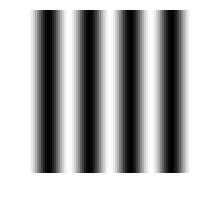

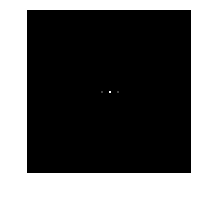

ValueError: operands could not be broadcast together with shapes (170,170) (84,84) 

In [21]:
# OTF
dim = 84
atf = np.zeros((dim, dim))
freq = 2
atf[int(dim/2), int(dim/2) - freq] = 1
atf[int(dim/2), int(dim/2) + freq] = 1

psf = np.square(np.abs(np.fft.ifft2(np.fft.fftshift(atf))))

plt.imshow(psf, cmap='gray')
plt.axis('off')
plt.gcf().set_size_inches(3, 3)
plt.show()

# convolve
otf = np.fft.fft2(np.fft.ifftshift(psf))
plt.imshow(np.square(np.fft.fftshift(np.abs(otf))), cmap='gray')
plt.axis('off')
plt.gcf().set_size_inches(3, 3)
plt.show()

Iout = np.fft.ifft2(np.fft.fft2(Ipad)*otf) 

plt.imshow(np.square(np.abs(Iout)), cmap='gray')
plt.axis('off')
plt.gcf().set_size_inches(3, 3)
plt.show()

In [41]:
np.save('maskopt/psf_9s_3x3.npy', np.square(np.abs(Iout)))

In [29]:
for j in range(10000):
    i = np.random.randint(0, 10000)
    I = np.reshape(mnist.train.images[i], (28,28))
    I = imresize(I, (40,40))
    
    # pad image
    pad_amt = 100
    Ipad = np.pad(I, ((pad_amt, pad_amt)), 'constant', constant_values = (0,0))
    
    imsave('/media/data/onn/mnistpadded240/mnist_pad_%04d.png' % (j), Ipad)


### Extract phase mask

In [70]:
def print_tensors_in_ckpt(ckpt_path):
    chkp.print_tensors_in_checkpoint_file(ckpt_path, 
                                          tensor_name='', all_tensors=False)
    
def load_variable_from_checkpoint(tensor_name, shape, ckpt_path, dtype=tf.float64):
    tf.reset_default_graph()

    # Load checkpoint from disk to compare phase shifts found by tensorflow
    tensor_graph = tf.get_variable(tensor_name, shape=shape, dtype=dtype)
    with tf.Session() as sess:
        saver = tf.train.Saver([tensor_graph])
        saver.restore(sess, ckpt_path)
        
        tensor_value = sess.run(tensor_graph)

    return tensor_value

INFO:tensorflow:Restoring parameters from /home/sci/workspace/onn/checkpoints/doublepsf/20171220-180402/PhaseMask_Test.ckpt-39500


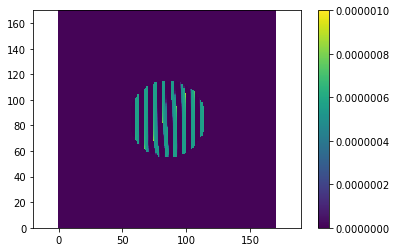

In [71]:
ckpt_path = '/media/data/checkpoints/onn/mnist_with_summaries/optconv-testing-2/train/'
# /home/sci/workspace/onn/checkpoints/doublepsf/20171220-180402/PhaseMask_Test.ckpt-39500
# print_tensors_in_ckpt(ckpt_path)
varname = 'model/phase_mask_height/height_map_sqrt'
var = load_variable_from_checkpoint(varname, [1,170,170,1], ckpt_path, dtype=tf.float64)
height_map = np.square(var.squeeze())

plt.pcolor(height_map, vmin=0, vmax=1e-6)
plt.colorbar()
plt.axis('equal')
plt.show()

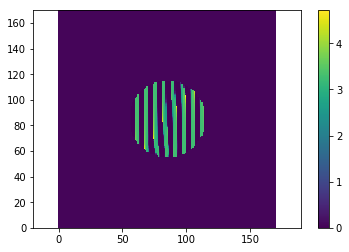

In [72]:
# Visualize phase mask instead
wavelength = 532 * 1e-9
n = 1.5
delta_n = n - 1.0002777
phi = (2*np.pi*delta_n/wavelength) * height_map
phimax = 1.5*np.pi;
phi = np.mod(phi, phimax)

plt.pcolor(phi, vmin=0, vmax=phimax)
plt.colorbar()
plt.axis('equal')
plt.show()


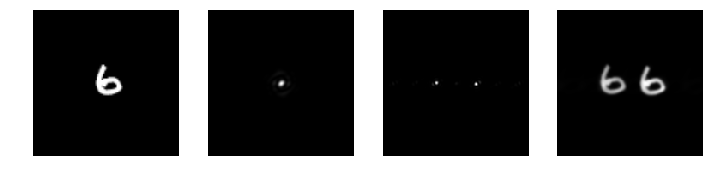

In [75]:
# Test phase mask
from scipy.misc import imread
I = imread('testing/mnist_pad_0010.png')
# I = np.zeros((84,84))
# I[44:45,30:60]=1
# I[30:60,44]=1
Ift = np.fft.fft2(I)

fig, ax = plt.subplots(nrows=1, ncols=4)
plt.subplot(141)
plt.imshow(I, cmap='gray')
plt.axis('off')
plt.subplot(142)
plt.imshow(np.square(np.abs(np.fft.fftshift(Ift))), cmap='gray')
plt.axis('off')

# convolve
[x, y] = np.mgrid[-85: 85, -85: 85].astype(np.float64)
max_val = np.amax(30)
r = np.sqrt(x ** 2 + y ** 2)
aperture_mask = r<max_val
atf = np.fft.ifftshift(aperture_mask * np.exp(1j*phi))
psf = np.square(np.abs(np.fft.ifft2(atf)))
plt.subplot(143)
plt.imshow(np.fft.fftshift(psf), cmap='gray')
plt.axis('off')

otf = np.fft.fft2(psf)
Iout = np.fft.ifft2(Ift*otf) 

plt.subplot(144)
plt.imshow(np.square(np.abs(Iout)), cmap='gray')
plt.axis('off')
plt.gcf().set_size_inches(12, 3)
plt.show()

In [66]:
# save phase mask as text file
np.savetxt('phasemask_2.txt', phi)